In [1]:
import os
os.getcwd()
os.chdir(r'/home/manhducnmd/Delphes-3.5.0')

In [4]:
os.environ["PATH"]='/home/manhducnmd/latex/bin/x86_64-linux'
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.family'] = 'sans-serif'

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import pickle

In [5]:
import ROOT
ROOT.gSystem.Load("libDelphes")

sh: 1: sed: not found
sh: 1: ldd: not found


Welcome to JupyROOT 6.20/08


0

In [6]:
try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

In [ ]:
Pt_background = []

P4_1_background = []
P4_2_background = []

Mjj_background = []
eta_1_background = []
eta_2_background = []

phi_1_background = []
phi_2_background = []

final_background_eta = []
final_background_phi = []
final_background_Pt = []

final_background_eta_2 = []
final_background_phi_2 = []
final_background_Pt_2 = []

final_background_first_mass_jet = []
final_background_second_mass_jet = []
final_background_mass_ratio = []
for number in [11]:
    for k in range(70, 99):
        #if k < 3:
            #inputFile= f'/home/manhducnmd/pp_dijet/Events/run_06_{k}/tag_2_delphes_events.root'
        #else:
        inputFile= f'/home/manhducnmd/pp_dijet/Events/run_{number}_{k}/tag_1_delphes_events.root'
        chain = ROOT.TChain("Delphes")
        chain.Add(inputFile)

        # Create object of class ExRootTreeReader
        treeReader = ROOT.ExRootTreeReader(chain)
        numberOfEntries = treeReader.GetEntries()
        print(numberOfEntries)
        # Get pointers to branches used in this analysis
        branchJet = treeReader.UseBranch("Jet")
        branchEFlowTrack = treeReader.UseBranch("EFlowTrack")
        branchEFlowPhoton = treeReader.UseBranch("EFlowPhoton")
        branchEFlowNeutralHadron = treeReader.UseBranch("EFlowNeutralHadron")


        for i in range(0, numberOfEntries): 
            treeReader.ReadEntry(i)

            if branchJet.GetEntries() >= 2:
                jet1 = branchJet.At(0)   # The first leading jet
                jet2 = branchJet.At(1)   # The second leading jet
                jetvec1= jet1.P4() 
                jetvec2= jet2.P4() 
                jet_total = jetvec1 + jetvec2
                jet1_mass = jetvec1.M()
                jet2_mass = jetvec2.M()
                if jetvec1.Pt() > 750 and jetvec2.Pt() > 750:
                    if np.abs(jetvec1.Eta()) < 2 and np.abs(jetvec2.Eta()) < 2:
                        if jet2_mass != 0:
                            jet_ratio = jet1_mass/jet2_mass
                            Pt_background.append(jetvec1.Pt()) 

                            P4_1_background.append(jetvec1)
                            P4_2_background.append(jetvec2)

                            Mjj_background.append(jet_total.M())
                            final_background_first_mass_jet.append(jet1_mass)
                            final_background_second_mass_jet.append(jet2_mass)
                            final_background_mass_ratio.append(jet_ratio)

                            eta_1_background.append(jetvec1.Eta())
                            eta_2_background.append(jetvec2.Eta())

                            phi_1_background.append(jetvec1.Phi())
                            phi_2_background.append(jetvec2.Phi())

                            constituent_background_eta = []
                            constituent_background_phi = []
                            constituent_background_Pt = []

                            constituent_background_eta_2 = []
                            constituent_background_phi_2 = []
                            constituent_background_Pt_2 = []
                            for constituent in jet1.Constituents: 
                                constituent_background_eta.append(constituent.P4().Eta())
                                constituent_background_phi.append(constituent.P4().Phi())
                                constituent_background_Pt.append(constituent.P4().Pt())
                            for constituent_2 in jet2.Constituents:
                                constituent_background_eta_2.append(constituent_2.P4().Eta())
                                constituent_background_phi_2.append(constituent_2.P4().Phi())
                                constituent_background_Pt_2.append(constituent_2.P4().Pt())

                            final_background_eta.append(constituent_background_eta)
                            final_background_phi.append(constituent_background_phi)
                            final_background_Pt.append(constituent_background_Pt)

                            final_background_eta_2.append(constituent_background_eta_2)
                            final_background_phi_2.append(constituent_background_phi_2)
                            final_background_Pt_2.append(constituent_background_Pt_2)

        chain.Reset()
'''
for p_i in [25, 50, 75]:
    all_images_background_sr = []
    all_images_background_sb = []

    all_images_background_sr_2 = []
    all_images_background_sb_2 = []
    # Grid settings
    xpixels = np.arange(-1, 1, 2/p_i)
    ypixels = np.arange(-1, 1, 2/p_i)

    # function to return the image momenta for centroid and principal axis
    def img_mom (x, y, weights, x_power, y_power):
        return ((x**x_power)*(y**y_power)*weights).sum()

    # returns the jet image
    def orig_image (etas, phis, es):
        """
        Gives the value on grid with minimal distance,
        eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
        """
        z = np.zeros((len(xpixels),len(ypixels)))
        in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
        xcoords = np.argmin(np.abs(etas[None,:] - xpixels[None,:,None]), axis = 1)
        ycoords = np.argmin(np.abs(phis[None,:] - ypixels[None,:,None]), axis = 1)
        z[xcoords[0][in_grid],ycoords[0][in_grid]] = es[in_grid]
        return z

    # preprocess the jet
    def preprocessing(x ,y, jet_eta, jet_phi, weights, rotate=True, flip=True):
        """
        (x,y) are the coordinates and weights the corresponding values, shifts
        centroid to origin, rotates image, so that principal axis is vertical,
        flips image, so that most weights lay in plane.
        Method for calculating principal axis (similar to tensor of inertia):
        https://en.wikipedia.org/wiki/Image_moment
        here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
        so possible issues with calculating the centroid
        -> pre-shifting of events outside of this function solves the problem
        for iamge-data with Delta_phi < 2*np.pi
        """

        # Shift
        #x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
        #y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
        x_centroid = jet_eta
        y_centroid = jet_phi
        x = x - x_centroid
        y = y - y_centroid
        if rotate:
            #Ccovariant matrix, eigenvectors corr. to principal axis
            u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
            u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
            u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
            cov = np.array([[u20, u11], [u11, u02]])

            # Eigenvalues and eigenvectors of covariant matrix
            evals, evecs = np.linalg.eig(cov)

            # Sorts the eigenvalues, v1, [::-1] turns array around, 
            sort_indices = np.argsort(evals)[::-1]
            e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
            e_2 = evecs[:, sort_indices[1]]

            # Theta to x_axis, arctan2 gives correct angle
            theta = np.arctan2(e_1[0], e_1[1])

            # Rotation, so that princple axis is vertical
            # anti-clockwise rotation matrix
            rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            transformed_mat = rotation * np.stack([x,y])
            x_rot, y_rot = transformed_mat.A
        else: 
            x_rot, y_rot = x, y

        n_flips = 0

        # Flipping
        if flip:
            if x_rot[np.argmax(weights)] < 0.:
                x_rot = -x_rot
                n_flips  += 1
            if y_rot[np.argmax(weights)] < 0.:
                y_rot = -y_rot
                n_flips += 1

        return x_rot, y_rot


    # function to convert the jet to an image
    def constit_to_img(etas, phis, jet_eta, jet_phi, pT, rotate, flip):

        phis[phis < -np.pi] += 2*np.pi
        phis[phis > np.pi] -= 2*np.pi

        weights = pT

        etas, phis = preprocessing(etas, phis, jet_eta, jet_phi, weights, rotate, flip)

        z_ori = orig_image(etas, phis, weights)

        return z_ori

    for idx, xd in enumerate(final_background_eta):
        etas = np.array(final_background_eta[idx])
        phis = np.array(final_background_phi[idx])
        Pts = np.array(final_background_Pt[idx])

        etas_2 = np.array(final_background_eta_2[idx])
        phis_2 = np.array(final_background_phi_2[idx])
        Pts_2 = np.array(final_background_Pt_2[idx])
        if 4700 <= Mjj_background[idx] <= 5500:
            all_images_background_sr.append(constit_to_img(etas, phis, eta_1_background[idx], 
                                                                   phi_1_background[idx], Pts, True, True))
            all_images_background_sr_2.append(constit_to_img(etas_2, phis_2, eta_2_background[idx], 
                                                                     phi_2_background[idx], Pts_2, True, True))
        elif  4400 <= Mjj_background[idx] <= 4700 or 5500 <= Mjj_background[idx] <= 5800:
            all_images_background_sb.append(constit_to_img(etas, phis, eta_1_background[idx], 
                                                               phi_1_background[idx], Pts, True, True))
            all_images_background_sb_2.append(constit_to_img(etas_2, phis_2, eta_2_background[idx], 
                                                                     phi_2_background[idx], Pts_2, True, True))
    all_images_background_sr = np.array(all_images_background_sr)
    all_images_background_sb = np.array(all_images_background_sb)

    all_images_background_sr_2 = np.array(all_images_background_sr_2)
    all_images_background_sb_2 = np.array(all_images_background_sb_2)



    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')
    with open(f'm_background_images_sr_{p_i}_jet_1.npy','wb') as f:
        np.save(f, all_images_background_sr)
    with open(f'm_background_images_sb_{p_i}_jet_1.npy', 'wb') as g:
        np.save(g, all_images_background_sb)
    with open(f'm_background_images_sr_{p_i}_jet_2.npy','wb') as fle:
        np.save(fle, all_images_background_sr_2)
    with open(f'm_background_images_sb_{p_i}_jet_2.npy', 'wb') as gle:
        np.save(gle, all_images_background_sb_2)
'''
Pt_background = np.array(Pt_background)

P4_1_background = np.array(P4_1_background)
P4_2_background = np.array(P4_2_background)

Mjj_background = np.array(Mjj_background)






100000
100000
100000
100000
100000
100000


print(np.shape())

In [12]:
final_background_mass_ratio = np.array(final_background_mass_ratio)

signal_criteria = (4700 <= Mjj_background) & (Mjj_background <= 5500)
sideband_criteria = ((4400 <= Mjj_background) & (Mjj_background <= 4700)) | (5500 <= Mjj_background) & (Mjj_background <= 5800)
final_background_mass_ratio_sr = final_background_mass_ratio[signal_criteria]
final_background_mass_ratio_sb = final_background_mass_ratio[sideband_criteria]

final_background_first_mass_jet = np.array(final_background_first_mass_jet)
final_background_first_mass_jet_sr = final_background_first_mass_jet[signal_criteria]
final_background_first_mass_jet_sb = final_background_first_mass_jet[sideband_criteria]

final_background_second_mass_jet = np.array(final_background_second_mass_jet)
final_background_second_mass_jet_sr = final_background_second_mass_jet[signal_criteria]
final_background_second_mass_jet_sb = final_background_second_mass_jet[sideband_criteria]

with open(f'm_background_sr_mass_ratio.npy','wb') as flee:
    np.save(flee, final_background_mass_ratio_sr)
with open(f'm_background_sb_mass_ratio.npy', 'wb') as glee:
    np.save(glee, final_background_mass_ratio_sb)

with open(f'm_background_sr_mass_jet_1.npy','wb') as hlee:
    np.save(hlee, final_background_first_mass_jet_sr)
with open(f'm_background_sb_mass_jet_1.npy', 'wb') as klee:
    np.save(klee, final_background_first_mass_jet_sb)

with open(f'm_background_sr_mass_jet_2.npy','wb') as mlee:
    np.save(mlee, final_background_second_mass_jet_sr)
with open(f'm_background_sb_mass_jet_2.npy', 'wb') as nlee:
    np.save(nlee, final_background_second_mass_jet_sb)

In [ ]:
#final_background_mass_ratio = np.array(final_background_mass_ratio)

signal_criteria = (4700 <= Mjj_background) & (Mjj_background <= 5500)
sideband_criteria = ((4400 <= Mjj_background) & (Mjj_background <= 4700)) | (5500 <= Mjj_background) & (Mjj_background <= 5800)

phi_1_background = np.array(phi_1_background)
phi_2_background = np.array(phi_2_background)

eta_1_background = np.array(eta_1_background)
eta_2_background = np.array(eta_2_background)

eta_1_signal_sr = eta_1_signal[signal_criteria]
eta_2_signal_sr = eta_2_signal[signal_criteria]

eta_1_signal_sb = eta_1_signal[sideband_criteria]
eta_2_signal_sb = eta_2_signal[sideband_criteria]

phi_1_signal_sr = phi_1_signal[signal_criteria]
phi_2_signal_sr = phi_2_signal[signal_criteria]

phi_1_signal_sb = phi_1_signal[sideband_criteria]
phi_2_signal_sb = phi_2_signal[sideband_criteria]


os.chdir(r'/home/manhducnmd/pp_dijet/Results_full
with open(f'{file[:-7]}_sr_eta_jet_1.npy', 'wb') as f:
    np.save(f, eta_1_signal_sr)
with open(f'{file[:-7]}_sr_eta_jet_2.npy', 'wb') as f:
    np.save(f, eta_2_signal_sr)

with open(f'{file[:-7]}_sb_eta_jet_1.npy', 'wb') as f:
    np.save(f, eta_1_signal_sb)

with open(f'{file[:-7]}_sb_eta_jet_2.npy', 'wb') as f:
    np.save(f, eta_2_signal_sb)

with open(f'{file[:-7]}_sr_phi_jet_1.npy', 'wb') as f:
    np.save(f, phi_1_signal_sr)

with open(f'{file[:-7]}_sr_phi_jet_2.npy', 'wb') as f:
    np.save(f, phi_2_signal_sr)

with open(f'{file[:-7]}_sb_phi_jet_1.npy', 'wb') as f:
    np.save(f, phi_1_signal_sb)

with open(f'{file[:-7]}_sb_phi_jet_2.npy', 'wb') as f:
    np.save(f, phi_2_signal_sb)


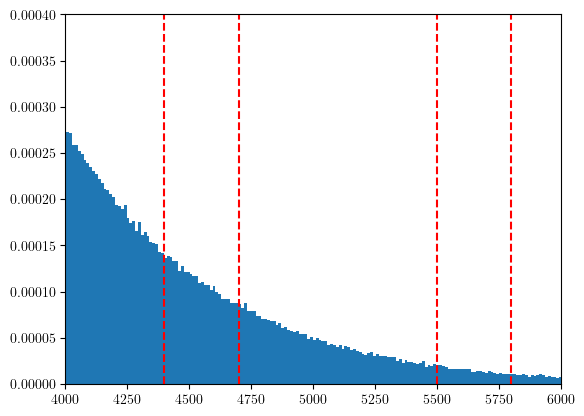

In [8]:
plt.hist(Mjj_background, bins = 'auto', density = True)
plt.axvline(x = 4400, ls = '--', c = 'r')
plt.axvline(x = 4700, ls = '--', c = 'r')
plt.axvline(x = 5500, ls = '--', c = 'r')
plt.axvline(x = 5800, ls = '--', c = 'r')
plt.xlim(4000,6000)
plt.ylim(0, 0.0004)
plt.show()

In [9]:
print(np.shape(all_images_background_sr))

(60371, 25, 25)


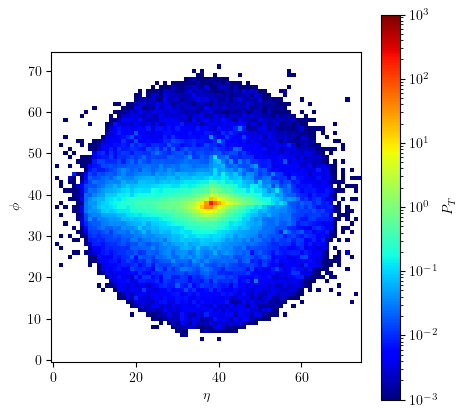

In [14]:
masked_data = np.ma.masked_equal(np.mean(all_images_background_sr[0:10000], axis = 0), 0.)

# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=10**-3, vmax=10**3)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("$P_T$")
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.gca().invert_yaxis()
plt.show()

In [11]:
print(len(all_images_background_sr), len(all_images_background_sb))

153648 157429
